In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

from scipy.spatial.distance import cdist

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics  import silhouette_score
set_config(display="diagram")

In [2]:
data = pd.read_csv("laptops.csv")
data.drop("old_price",axis=1, inplace=True)
print(data.shape)
data.head()

(205, 9)


,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64 GB (eMMC),1259.0,0 / 5
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1 TB HDD,1849.0,3.3 / 5
2,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256 GB SSD,2999.0,0 / 5
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1 TB HDD,1849.0,0 / 5
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1 TB HDD,2499.0,0 / 5


## Data Preprocessing

In [3]:
data.isnull().sum()

brand             0
img_url           1
laptop_name       1
display_size      0
processor_type    0
graphics_card     0
disk_space        0
discount_price    0
ratings_5max      0
dtype: int64

In [4]:
data.dropna(inplace=True)

In [5]:
cols = data.dtypes[data.dtypes == "object"].index
for col in cols:
    data[col] = data[col].apply(lambda x: x.strip())
data.head()

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64 GB (eMMC),1259.0,0 / 5
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1 TB HDD,1849.0,3.3 / 5
2,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256 GB SSD,2999.0,0 / 5
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1 TB HDD,1849.0,0 / 5
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1 TB HDD,2499.0,0 / 5


### Extracting the ratings of the laptops

In [6]:
data.ratings_5max = data.ratings_5max.apply(lambda x: float(x.strip().split()[0]))
data.head()

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64 GB (eMMC),1259.0,0.0
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1 TB HDD,1849.0,3.3
2,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256 GB SSD,2999.0,0.0
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1 TB HDD,1849.0,0.0
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1 TB HDD,2499.0,0.0


In [7]:
data.disk_space.apply(lambda x: x.split()[-1]).unique()

array(['(eMMC)', 'HDD', 'SSD', 'SSD)', 'Flash)'], dtype=object)

In [8]:
typeDict = {'(eMMC)': 'eMMC', 'HDD': 'HDD', 'SSD': 'SSD', 'SSD)': 'SSD', 'Flash)': 'Flash'}
data['disk_type'] = data['disk_space'].map(lambda x: typeDict[x.split()[-1]])
data['disk_space'] = data['disk_space'].apply(lambda x: float(x.split()[0])*1024 if x.split()[1] == 'TB' else float(x.split()[0]))
data.head()

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD
2,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD


In [9]:
list(enumerate(data.columns))

[(0, 'brand'),
 (1, 'img_url'),
 (2, 'laptop_name'),
 (3, 'display_size'),
 (4, 'processor_type'),
 (5, 'graphics_card'),
 (6, 'disk_space'),
 (7, 'discount_price'),
 (8, 'ratings_5max'),
 (9, 'disk_type')]

In [10]:
data1 = data.drop(["img_url", "laptop_name"], axis=1)

In [11]:
pipeline = Pipeline([
    ("tnf1", ColumnTransformer([
        ("one_hot_encoding", OneHotEncoder(dtype="int", sparse_output=False, handle_unknown="ignore"), [0,7]),
        ("scaling", StandardScaler(), [1, 5, 6]),
        ("ordinal_encoding", OrdinalEncoder(), [2, 3, 4])
    ], remainder="drop"))
])

pipeline.fit(data1.values)

Pipeline(steps=[('tnf1',
                 ColumnTransformer(transformers=[('one_hot_encoding',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 7]),
                                                 ('scaling', StandardScaler(),
                                                  [1, 5, 6]),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(),
                                                  [2, 3, 4])]))])

In [12]:
x = pipeline.transform([["HP", 14.0, "Intel Celeron N4000", "NVIDIA GeForce MX150 (2 GB)", 64.0, 2344.0, 2.5, "SSD"]])[0]
x

array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        , -0.51443978, -0.6419836 ,
        0.52480414,  4.        , 44.        ,  3.        ])

In [13]:
data2 = pipeline.transform(data1.values)

In [14]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 100)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init="auto").fit(data2)
    kmeanModel.fit(data2)
  
    distortion = sum(np.min(cdist(data2, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / data2.shape[0]
    distortions.append(distortion)
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = distortion
    mapping2[k] = kmeanModel.inertia_

In [15]:
pd.DataFrame([pd.Series(mapping1, name="Distortions"), pd.Series(mapping2, name="Inertias")]).T

,Distortions,Inertias
1,14.286775,51225.059113
2,8.858401,19210.282484
3,6.572700,10338.340195
4,5.647534,7335.316459
5,5.424875,7130.833844
...,...,...
95,0.725529,172.369349
96,0.718367,168.293404
97,0.700859,161.919923
98,0.690072,154.566480


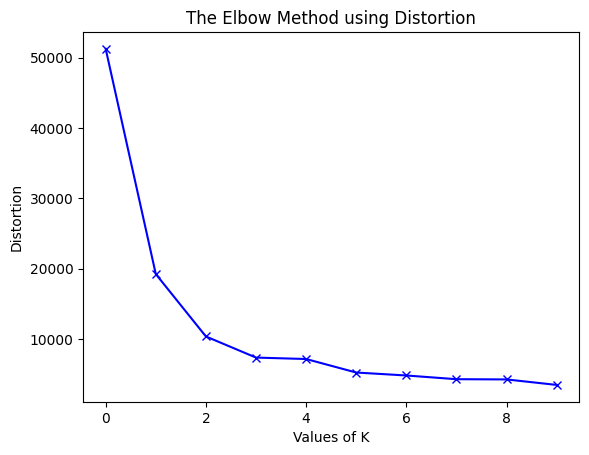

In [16]:
plt.plot(range(10), inertias[:10], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### Adding Clustering algorithm to the pipipeline

In [17]:
pipeline.steps.append(("estimator", KMeans(n_clusters=3, n_init="auto")))

In [18]:
pipeline["estimator"].fit(data2)

KMeans(n_clusters=3, n_init='auto')

In [19]:
data1["cluster"] = pipeline.predict(data1.values)
data1

,brand,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,cluster
0,HP,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC,0
1,Lenovo,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD,0
2,Huawei,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD,2
3,Dell,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD,0
4,Asus,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD,0
...,...,...,...,...,...,...,...,...,...
199,Dell,15.6,Intel Core i5-7200U,AMD Radeon R5-M430 (2 GB),1024.0,2249.0,3.3,HDD,1
200,Lenovo,15.6,Intel Core i5-8250U,Intel GMA HD,1024.0,2099.0,3.8,HDD,1
201,Huawei,15.6,Intel Core i7-8550U,NVIDIA GeForce MX150 (2 GB),128.0,3299.0,4.0,HDD,2
202,Apple,15.4,Intel Core i7 6 Core,Radeon Pro 555X GDDR5 (4 GB),256.0,10199.0,0.0,SSD,2


In [20]:
cluster = pipeline.predict([["HP", 14.0, "Intel Celeron N4000", "NVIDIA GeForce MX150 (2 GB)", 64.0, 2344.0, 2.5, "SSD"]])[0]
cluster

2

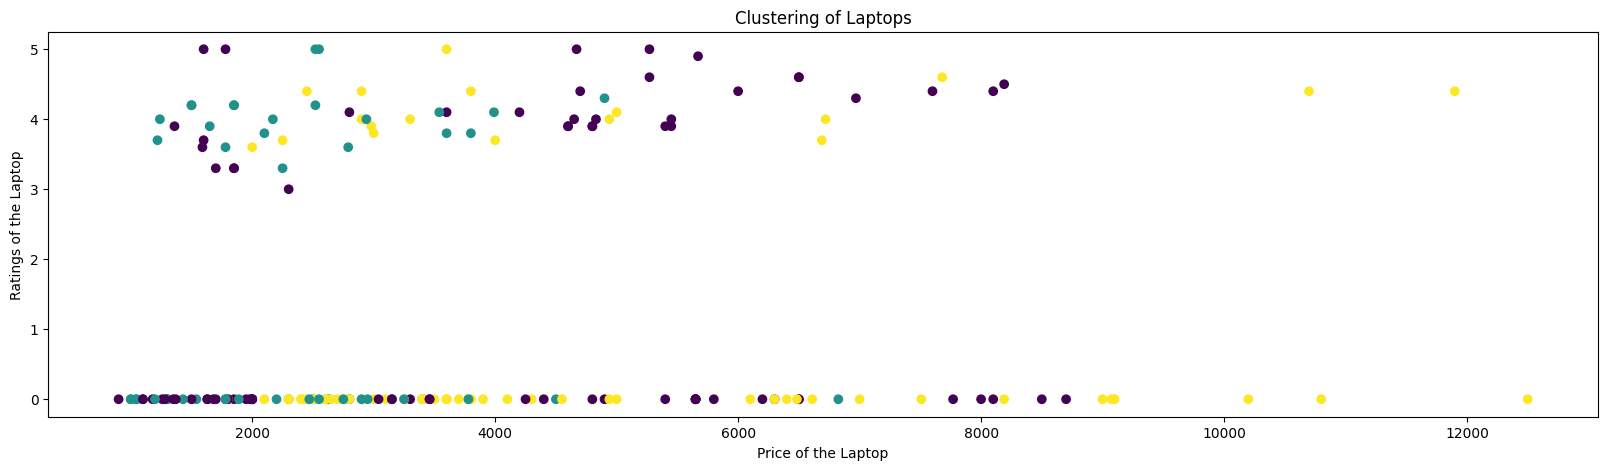

In [21]:
plt.figure(figsize=(20,5))
plt.scatter(x=data1['discount_price'],y=data1['ratings_5max'],c=data1['cluster'])
plt.xlabel("Price of the Laptop")
plt.ylabel("Ratings of the Laptop")
plt.title("Clustering of Laptops")
plt.show()

In [22]:
user_pref = pd.DataFrame({
    "brand": ["HP"],
    "display_size": [15.6],
    "processor_type": ["Intel Celeron N4000"],
    "graphics_card": ["Intel HD Graphics 600"],
    "disk_space": [1024.0],
    "discount_price": [2000.0],
    "ratings_5max": [4.0],
    "disk_type": ["eMMC"]
})

user_pref

,brand,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type
0,HP,15.6,Intel Celeron N4000,Intel HD Graphics 600,1024.0,2000.0,4.0,eMMC


In [23]:
cluster = pipeline.predict(user_pref.values)[0]
cluster

0

In [24]:
recommended_laptops = data[data1['cluster'] == cluster][['brand','processor_type','graphics_card','display_size','img_url']]
recommended_laptops.head()

,brand,processor_type,graphics_card,display_size,img_url
0,HP,Intel Celeron N4000,Intel HD Graphics 600,14.0,https://encrypted-tbn0.gstatic.com/images?q=tb...
1,Lenovo,Intel Core i5-8250U,Intel UHD Graphics 620,14.0,https://encrypted-tbn0.gstatic.com/images?q=tb...
3,Dell,Intel Core i3-7020U,Intel HD Graphics 620,15.6,https://encrypted-tbn0.gstatic.com/images?q=tb...
4,Asus,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),15.6,https://encrypted-tbn0.gstatic.com/images?q=tb...
6,Apple,Intel Core i5 Dual Core,Intel UHD Graphics 617,13.3,https://encrypted-tbn0.gstatic.com/images?q=tb...


In [ ]:
class Recommender(Pipeline):
    def __init__(self, *args):
        super().__init__(*args)
    
    def get_k_recommendations()